<a href="https://colab.research.google.com/github/Chicken2322/Stock-Prediction/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
pip install pmdarima


In [9]:
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#setting scaler in the the range between 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
df = pd.read_csv("/content/drive/My Drive/reliance_data.csv")
df=df.dropna()

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6034 entries, 0 to 6159
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6034 non-null   object 
 1   Open       6034 non-null   float64
 2   High       6034 non-null   float64
 3   Low        6034 non-null   float64
 4   Close      6034 non-null   float64
 5   Adj Close  6034 non-null   float64
 6   Volume     6034 non-null   float64
dtypes: float64(6), object(1)
memory usage: 377.1+ KB


In [ ]:
df.head()





,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,16.009800,16.095699,15.904300,16.0683,2.431136,47600787.0
1,1996-01-02,16.029301,16.107401,15.826200,15.9434,2.412238,77143764.0
2,1996-01-03,16.205000,16.943001,16.029301,16.0644,2.430546,95695836.0
3,1996-01-04,15.912100,15.962900,15.701300,15.9160,2.408093,99159504.0
4,1996-01-05,15.853600,15.853600,15.670000,15.8067,2.391556,76213503.0


In [ ]:
#We are converting date into date_time objects and setting it as index
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.sort_index(ascending=True, axis=0)

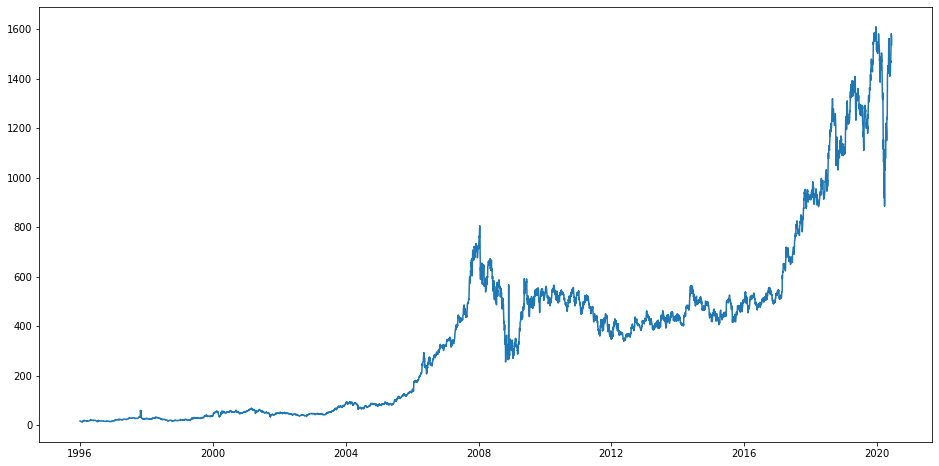

In [ ]:
#plotting the closing price of the company 
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [ ]:
#Now we are analysing our data by Moving Average Method and creating dataframe with date  
#and the target variable( In this case , CLOSING PRICE)
data = pd.DataFrame(data={'Date':df.Date,'Close': df.Close})
data.info()
data.size

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6034 entries, 1996-01-01 to 2020-06-09
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6034 non-null   datetime64[ns]
 1   Close   6034 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 141.4 KB


12068

In [ ]:
#While splitting the data into train and validation set
#we cannot use random splitting since that will destroy the time component
#So here we slice the data 
length = int(data.size / data.columns.size * 0.92)
train = data[:length]
valid = data[length:]


In [ ]:
print('Shape of training set:')
print(train.shape)

print('\n Shape of validation set:')
print(valid.shape)

Shape of training set:
(5551, 2)

 Shape of validation set:
(483, 2)


<Figure size 432x288 with 0 Axes>

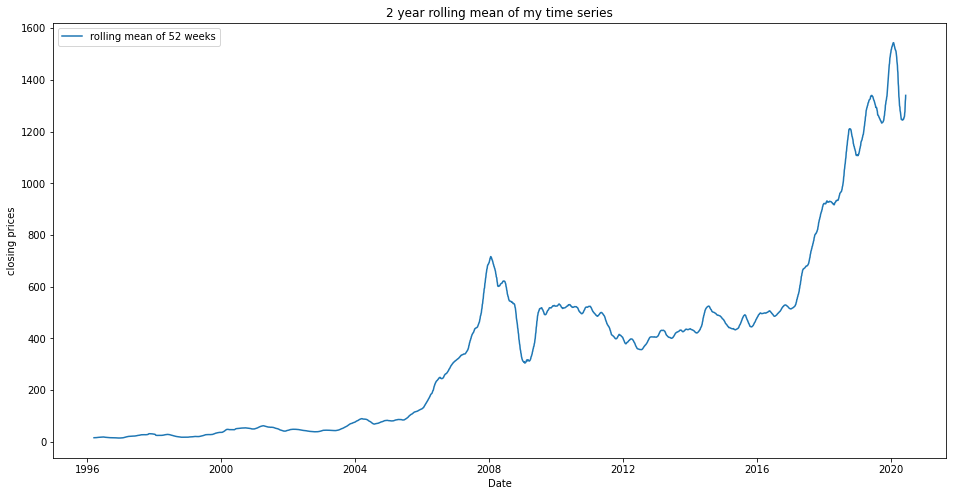

In [ ]:
#Using rolling mean from Moving Average library 
plt.clf()
plt.figure(figsize=(16,8))
data_mean = data.rolling(window=52).mean()
plt.plot(data_mean ,label="rolling mean of 52 weeks" )
plt.xlabel("Date")
plt.ylabel("closing prices")
plt.title("2 year rolling mean of my time series")
plt.legend(loc="upper left")
plt.show()

In [ ]:
preds=[]
valid_size= valid.Close.size
train_size= train.Close.size
for i in range(0 , valid_size):
    a = train['Close'][train_size - 365 + i:].sum() + sum(preds)
    b = a/365
    preds.append(b)

In [ ]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
406.99209506820705


<Figure size 432x288 with 0 Axes>

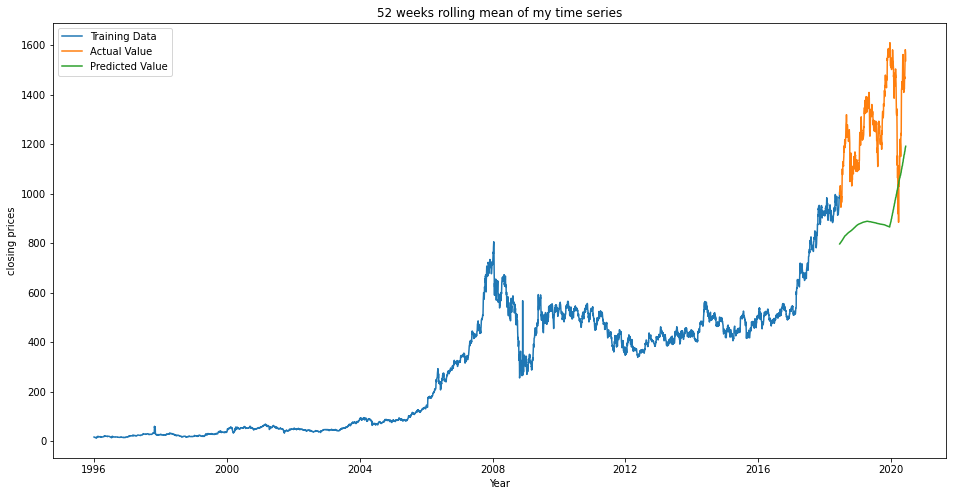

In [ ]:
#plotting prediction we did using Moving Average (Manually)
plt.clf()
plt.figure(figsize=(16,8))
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'], label="Training Data")
plt.plot(valid[['Close']] , label='Actual Value')
plt.plot(valid[[ 'Predictions']] , label='Predicted Value')

plt.xlabel("Year")
plt.ylabel("closing prices")
plt.title("52 weeks rolling mean of my time series")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Now we implement Linear regression model 
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [ ]:
new_data.Date = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]


In [ ]:
new_data.info()
new_data_length = int(new_data.size % new_data.columns.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034 entries, 0 to 6033
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6034 non-null   datetime64[ns]
 1   Close   6034 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 94.4+ KB


In [ ]:
new_data['Dayofweek']=new_data.Date.dt.dayofweek

In [ ]:
new_data['days'] = new_data.Date.dt.day
new_data['month'] = new_data.Date.dt.month
new_data['mon_fri'] = 0
for i in range(0,new_data_length):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

In [ ]:
#split into train and validation
length = int(new_data.size / new_data.columns.size * 0.92)
train = new_data[:length]
valid = new_data[length:]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5551 entries, 0 to 5550
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5551 non-null   datetime64[ns]
 1   Close      5551 non-null   object        
 2   Dayofweek  5551 non-null   int64         
 3   days       5551 non-null   int64         
 4   month      5551 non-null   int64         
 5   mon_fri    5551 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 260.3+ KB


In [ ]:
x_train = train.drop('Close', axis=1)
x_train['new_Date']=x_train['Date'].astype(str)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
x_valid['new_Date']=x_valid['Date'].astype(str)
y_valid = valid['Close']

In [ ]:
x_train.head()

,Date,Dayofweek,days,month,mon_fri,new_Date
0,1996-01-01,0,1,1,0,1996-01-01
1,1996-01-02,1,2,1,0,1996-01-02
2,1996-01-03,2,3,1,0,1996-01-03
3,1996-01-04,3,4,1,0,1996-01-04
4,1996-01-05,4,5,1,0,1996-01-05


In [ ]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train[['Dayofweek'	,'month']],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid[['Dayofweek','month']])
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

1000.8105366168345

<Figure size 432x288 with 0 Axes>

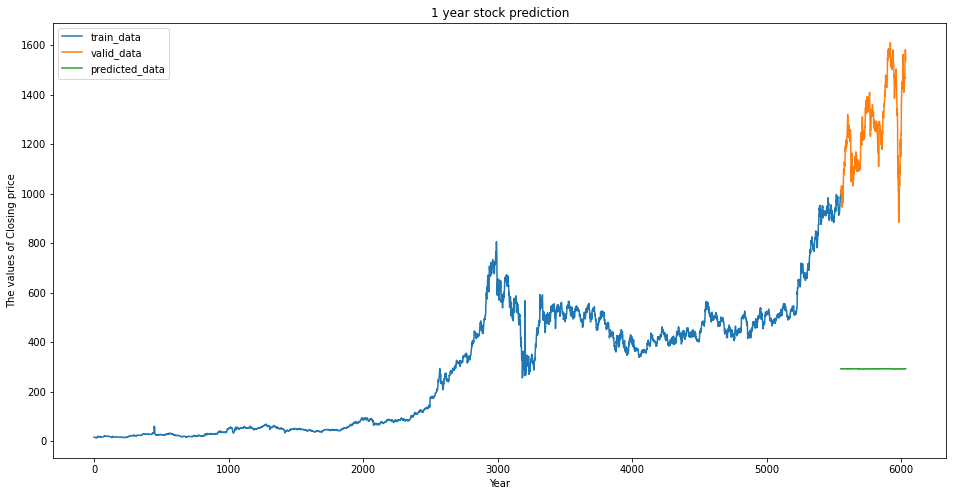

In [ ]:
plt.clf()
plt.figure(figsize=(16,8))
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[length:].index
train.index = new_data[:length].index

plt.plot(train['Close'],label='train_data')
plt.plot(valid[['Close']],label='valid_data')
plt.plot(valid[['Predictions']],label='predicted_data')
plt.xlabel("Year")
plt.ylabel("The values of Closing price")
plt.title("1 year stock prediction")
plt.legend(loc="upper left")
plt.show()

In [11]:
# Now we implement ARIMA models (Auto Regressive Integrated Moving Average)
data = df.sort_index(ascending=True, axis=0)
length = int(data.size / data.columns.size * 0.96)

train = data[:length]
valid = data[length:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast_data = model.predict(n_periods=validation.size)
forecast_data = pd.DataFrame(forecast_data,index = valid.index,columns=['Prediction'])


Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=43082.524, BIC=43115.834, Time=67.886 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=46698.694, BIC=46712.018, Time=0.442 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=45118.980, BIC=45145.628, Time=9.441 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=43097.603, BIC=43124.250, Time=50.647 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=46696.694, BIC=46703.356, Time=0.251 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=46369.136, BIC=46395.784, Time=23.389 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=43060.803, BIC=

In [12]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast_data['Prediction'])),2)))
print("RMS value from ARIMA Model {}".format(rms))

RMS value from ARIMA Model 158.53371413023706


<Figure size 432x288 with 0 Axes>

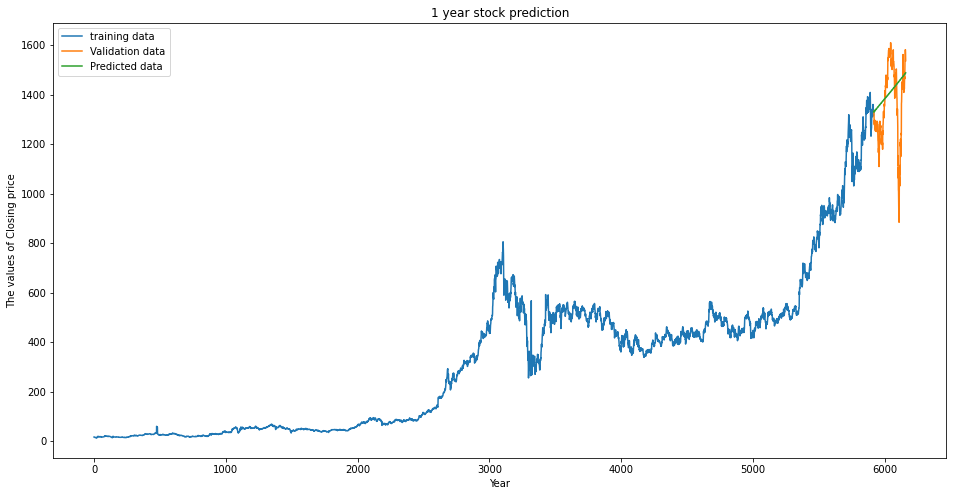

In [13]:
#plotting prediction we did using ARIMA models
plt.clf()
plt.figure(figsize=(16,8))
plt.plot(train['Close'],label="training data")
plt.plot(valid['Close'],label="Validation data")
plt.plot(forecast_data['Prediction'],label="Predicted data")
plt.xlabel("Year")
plt.ylabel("The values of Closing price")
plt.title("1 year stock prediction")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Now we implement LSTM models (Auto Regressive Integrated Moving Average)
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [ ]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [ ]:
dataset = new_data.values
length = int(dataset.size * 0.96)
train = dataset[0:length,:]
valid = dataset[length:,:]


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1


In [ ]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [ ]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print("Rms value {}".format(rms))

Rms value 130.24887906174553


<Figure size 432x288 with 0 Axes>

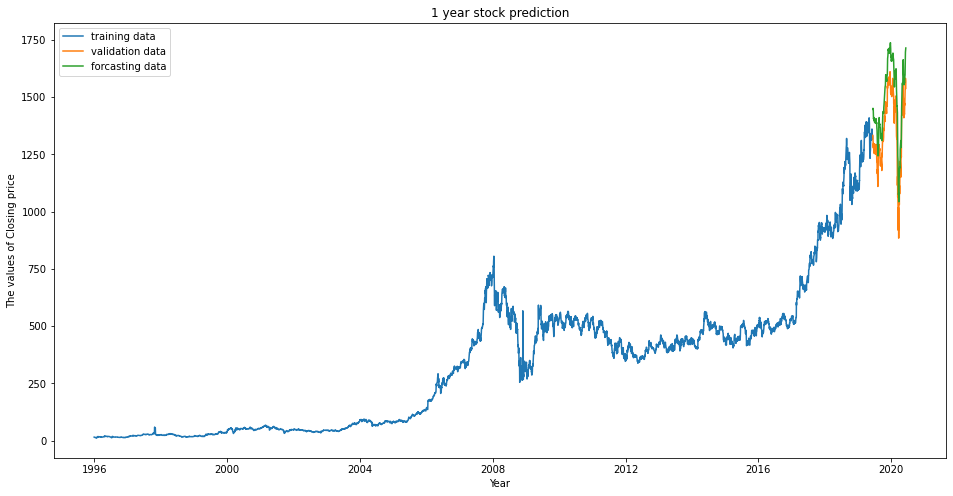

In [ ]:
#plotting the forcast values
plt.clf()
plt.figure(figsize=(16,8))
train = new_data[:length]
valid = new_data[length:]
valid['Predictions'] = closing_price
plt.plot(train['Close'],label="training data")
plt.plot(valid[['Close']],label="validation data")
plt.plot(valid[['Predictions']],label="forcasting data")
plt.xlabel("Year")
plt.ylabel("The values of Closing price")
plt.title("1 year stock prediction")
plt.legend(loc="upper left")
plt.show()
